In [1]:
import torch
import treescope
import numpy as np

from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from diffusers.utils import pt_to_pil
from evotorch import Problem, Solution, SolutionBatch
from evotorch.core import SolutionBatchPieces
from evotorch.decorators import vectorized
from evotorch.algorithms import CMAES, SNES
from evotorch.logging import StdOutLogger, PandasLogger
from diffusion_pt import diffusion_sample
from fitness_fn import brightness, clip_fitness_fn, compose_fitness_fns
import matplotlib.pyplot as plt

treescope.register_as_default()
treescope.basic_interactive_setup()

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"
pipeline = DiffusionPipeline.from_pretrained(
    model_id,
    use_safetensors=True,
    cache_dir="D:/Huggingface/"

).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [27]:
### Hardcoded but we can mess with it.
MANUAL_POP_SIZE = 4
NUM_SPLITS = 2
# NUM_SPLITS = MANUAL_POP_SIZE
SAMPLE_BATCH_SIZE=MANUAL_POP_SIZE // NUM_SPLITS

In [ ]:
num_inference_steps = 10
sample_fn, latents, num_inference_steps = diffusion_sample(pipeline, ["a dog"], num_inference_steps, torch.Generator(device=device), guidance_scale=7.5, batch_size=SAMPLE_BATCH_SIZE)

### just messing around. not important.
clip_prompts = ["a white dog", "a golden retriever"]
clip_scores = [-1.0] * len(clip_prompts)
clip_fits = []

for prompt in clip_prompts:
	clip_fits.append(clip_fitness_fn("openai/clip-vit-large-patch14", [prompt], cache_dir="D:/Huggingface/"))

# fit = compose_fitness_fns([*clip_fits, brightness], [*clip_scores, 0.1])
fit = compose_fitness_fns([*clip_fits], [*clip_scores])

Device set to use cuda:0
Device set to use cuda:0


In [29]:
def fitness_inner_compute(x : torch.Tensor, random_vec : torch.Tensor, mean_scale : float) -> torch.Tensor:
    if len(x.shape) < 2:
      x = x.unsqueeze(0)

    xb, xc = x.shape
    rb, rh, rw, rc = random_vec.shape
    print(f"x shape {x.shape}")

    y = torch.empty(xb, rh, rw, rc, dtype=torch.float32, device=x.device)
    print(f"y shape {y.shape}")

    mean, cov_diag = x.chunk(2, dim=-1)
    mean = mean.to(device, dtype=torch.float32)
    cov_diag = cov_diag.to(device, dtype=torch.float32)
    print(f"mean shape {mean.shape}\ncov_diag shape {cov_diag.shape}\nrandom_vec shape {random_vec.shape}")
    
    ###
    ### Unsure about this part - the random_vec[0:1] is not really correct (the purpose of doing this is to broadcast the random_vec)
    ###
    for idx in range(xb):
      y[idx] = mean_scale * mean[idx] + random_vec[0:1] * cov_diag[idx]

    y = y.permute(0, 3, 1, 2)
    return y


def fitness(sample_fn, latent_shape, fitness_fn, num_inference_steps, mean_scale=1e-2):
  b, c, h, w = latent_shape
  random_vec = torch.zeros(b, h, w, c).to(device, dtype=torch.float32)
  
  def _fitness(x):
    print(f"_fitness: x shape {x.shape}")

    x = x.reshape(-1, c * 2)
    x = fitness_inner_compute(x, random_vec, mean_scale)
    sample = sample_fn(x)

    sample_fitnesses = None
    sample_fitness = None

    ### I think this is slightly different from what we are after
    ### Sampling is actually the thing that takes all the time, thus I think we should do that in a batched way
    ### But compute the fitness function for the sample is really not so bad.
    ### TODO: vectorize the fitness_fn(...) so we don't have to do this
    ### Sample once, but do compute fitness in a for loop
    if len(x.shape) > 1:
      popsize = x.shape[0]
      sample_fitnesses = torch.empty(popsize, 1, dtype=torch.float32, device=x.device)
      for pop_idx in range(popsize):
        sample_fitnesses[pop_idx] = fitness_fn(sample[pop_idx:pop_idx+1])
    else:
      sample_fitness = fitness_fn(sample)

    return sample_fitness or sample_fitnesses
  
  return _fitness, random_vec

In [30]:
### Custom Problem Class
class VectorizedProblem(Problem):
  def __init__(self, fitness_fn, solution_length : int, device : torch.device, splits : int):
    super().__init__(
      "max",
      fitness_fn,
      solution_length=solution_length,
      initial_bounds=(-1, 1),
      dtype=np.dtype('float32'),
      device=device
    )

    self.splits = splits


  def _evaluate_batch(self, solutions : SolutionBatch) -> None:
    self._evaluate_batch_override_split_k(solutions)


  def _evaluate_batch_override_split_k(self, solutions : SolutionBatch) -> None:
    ### Baseline implementation - behaves like default
    # for solution in solutions:
    #     self._evaluate(solution)

    ### Slice the solutions
    solution_batch_splits = SolutionBatchPieces(batch=solutions, num_pieces=self.splits)
    split_all_result_list = []

    ### Compute a few at a time
    for iteration_idx in range(len(solution_batch_splits)):
      solution_split = solution_batch_splits[iteration_idx]
      split_result_tensor = self._objective_func(solution_split.values)
      print(f"split_result_tensor {split_result_tensor}")
      split_all_result_list.append(split_result_tensor)

    split_all_result_tensor = torch.cat(split_all_result_list, dim=0)

    print(f"split_all_result_tensor.shape {split_all_result_tensor.shape}")
    solutions.set_evals(split_all_result_tensor)


In [31]:
mean_scale = 1e-2
manual_pop_size = MANUAL_POP_SIZE

fitness_fn, random_vec = fitness(sample_fn, latents.shape, fit, num_inference_steps, mean_scale=mean_scale)
problem = VectorizedProblem(fitness_fn, solution_length=latents.shape[1] * 2, device=device, splits=NUM_SPLITS)
searcher = CMAES(problem, popsize=manual_pop_size, stdev_init=1)
logger = StdOutLogger(searcher)
pandas_logger = PandasLogger(searcher)

[2025-01-01 04:59:48] INFO     <36688> evotorch.core: Instance of `VectorizedProblem` (id:1900640263040) -- The `dtype` for the problem's decision variables is set as torch.float32
[2025-01-01 04:59:48] INFO     <36688> evotorch.core: Instance of `VectorizedProblem` (id:1900640263040) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2025-01-01 04:59:48] INFO     <36688> evotorch.core: Instance of `VectorizedProblem` (id:1900640263040) -- The `device` of the problem is set as cuda
[2025-01-01 04:59:48] INFO     <36688> evotorch.core: Instance of `VectorizedProblem` (id:1900640263040) -- The number of actors that will be allocated for parallelized evaluation is 0


c:\Anaconda3\envs\difftraj\Lib\site-packages\evotorch\tools\misc.py:1107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(data, **kwargs)


0it [00:00, ?it/s]

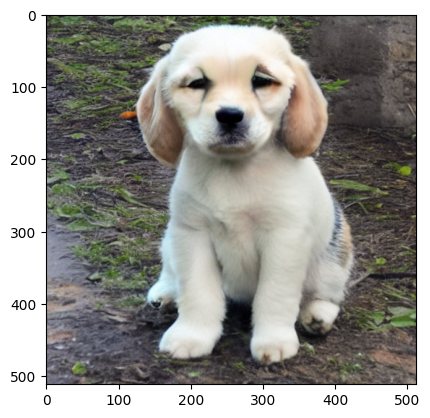

In [25]:
initial_image = sample_fn(random_vec.permute(0, 3, 1, 2))
plt.imshow(pt_to_pil(initial_image)[0])
plt.show()

_fitness: x shape torch.Size([2, 8])
x shape torch.Size([2, 8])
y shape torch.Size([2, 64, 64, 4])
mean shape torch.Size([2, 4])
cov_diag shape torch.Size([2, 4])
random_vec shape torch.Size([2, 64, 64, 4])


0it [00:00, ?it/s]

split_result_tensor tensor([[-0.3774],
        [ 1.7983]], device='cuda:0')
_fitness: x shape torch.Size([2, 8])
x shape torch.Size([2, 8])
y shape torch.Size([2, 64, 64, 4])
mean shape torch.Size([2, 4])
cov_diag shape torch.Size([2, 4])
random_vec shape torch.Size([2, 64, 64, 4])


0it [00:00, ?it/s]

split_result_tensor tensor([[-0.0457],
        [ 1.3636]], device='cuda:0')
split_all_result_tensor.shape torch.Size([4, 1])
         iter : 1
     stepsize : 0.9284839034080505
  median_eval : -0.045689284801483154
pop_best_eval : 1.7982548475265503
    mean_eval : 0.6846859455108643

x shape torch.Size([1, 8])
y shape torch.Size([1, 64, 64, 4])
mean shape torch.Size([1, 4])
cov_diag shape torch.Size([1, 4])
random_vec shape torch.Size([2, 64, 64, 4])


0it [00:00, ?it/s]

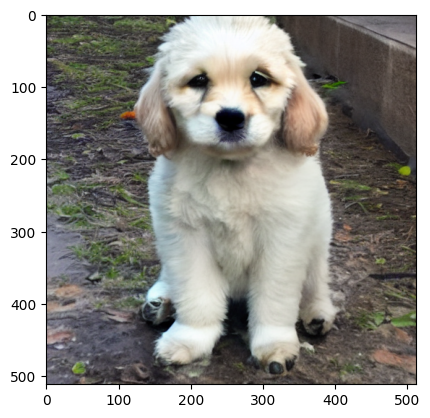

_fitness: x shape torch.Size([2, 8])
x shape torch.Size([2, 8])
y shape torch.Size([2, 64, 64, 4])
mean shape torch.Size([2, 4])
cov_diag shape torch.Size([2, 4])
random_vec shape torch.Size([2, 64, 64, 4])


0it [00:00, ?it/s]

split_result_tensor tensor([[0.1263],
        [1.5196]], device='cuda:0')
_fitness: x shape torch.Size([2, 8])
x shape torch.Size([2, 8])
y shape torch.Size([2, 64, 64, 4])
mean shape torch.Size([2, 4])
cov_diag shape torch.Size([2, 4])
random_vec shape torch.Size([2, 64, 64, 4])


0it [00:00, ?it/s]

KeyboardInterrupt: 

In [32]:
a = initial_image

for step in range(25):
  searcher.step()
  best_idx = searcher.population.argbest()

  x = searcher.population[best_idx].values
  x = x.reshape(-1, 8)
  x = fitness_inner_compute(x, random_vec, mean_scale)

  a = sample_fn(x)
  
  plt.imshow(pt_to_pil(a)[0])
  plt.show()

In [ ]:
my_data_frame = pandas_logger.to_dataframe()
my_data_frame["median_eval"].plot()
plt.show()

In [9]:
def fitness(sample_fn, latent_shape, fitness_fn, num_inference_steps, mean_scale=1e-2):
  b, c, h, w = latent_shape
  def _fitness(x):
    x = x.reshape(latent_shape).to(device) * mean_scale
    sample = sample_fn(x)
    return fitness_fn(sample)
  return _fitness

In [ ]:
mean_scale = 0.1
fitness_fn = fitness(sample_fn, latents.shape, fit, num_inference_steps, mean_scale=mean_scale)
problem = Problem("max", fitness_fn, solution_length=np.prod(latents.shape) , initial_bounds=(-4, 4), dtype=np.dtype('float32'))
searcher = SNES(problem, stdev_init=1)
logger = StdOutLogger(searcher)
pandas_logger = PandasLogger(searcher)

In [ ]:
a = sample_fn()
plt.imshow(pt_to_pil(a)[0])
plt.show()
for step in range(25):
  searcher.step()
  best_idx = searcher.population.argbest()
  x = searcher.population[best_idx].values

  a = sample_fn(x.reshape(latents.shape).to(device) * mean_scale)
  plt.imshow(pt_to_pil(a)[0])
  plt.show()